## Imports

In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

# 1: Data Preprocessing

## 1.1: Loading GameData.csv Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('GameData.csv')

# Preliminary data exploration
print("--------------")
print("Dataset shape (rows x columns): ")
print(data.shape)
print("--------------")

print("\nDataset information: ")
print(data.info())
print("--------------")

print("\nDataset summary statistics: ")
print(data.describe())
print("--------------")

print("\nDataset snapshot (Head): ")
print(data.head())


--------------
Dataset shape (rows x columns): 
(403, 386)
--------------

Dataset information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Columns: 386 entries, GameName to UCT
dtypes: float64(5), int64(377), object(4)
memory usage: 1.2+ MB
None
--------------

Dataset summary statistics: 
       String_java.lang.String     Off_int     End_int     int_int  \
count               403.000000  403.000000  403.000000   14.000000   
mean                 24.970223    0.362283    0.133995   39.571429   
std                 115.039293    1.175101    0.720635   58.952020   
min                   2.000000    0.000000    0.000000    2.000000   
25%                   6.000000    0.000000    0.000000    4.500000   
50%                   9.000000    0.000000    0.000000    8.500000   
75%                  17.000000    0.000000    0.000000   42.000000   
max                1909.000000   12.000000    8.000000  203.000000   

       Undefined_int  Piece_game.equipment.compo

## 1.2: Checking and Handelling Null Values


In [ ]:
# Check for missing values
missing_values = data.isnull().sum()

# Filtering columns with missing values
missing_values = missing_values[missing_values > 0]

# Display missing values
print("\nMissing Values per Column:")
print(missing_values)

# Drop 'int_int' column: Contains 389/403 null values
data = data.drop(columns=['int_int'])

print("\nDropped 'int_int' column.")

print("\n--------------")

print("\nColumns after dropping 'int_int':")
print(data.columns.tolist())
print("\n--------------")



Missing Values per Column:
int_int                                       389
Board_game.equipment.container.board.Board      1
Equipment_game.equipment.Equipment              1
To_game.functions.ints.iterator.To              3
dtype: int64

Dropped 'int_int' column.

--------------

Columns after dropping 'int_int':
['GameName', 'String_java.lang.String', 'Off_int', 'End_int', 'Undefined_int', 'Piece_game.equipment.component.Piece', 'Board_game.equipment.container.board.Board', 'MancalaBoard_game.equipment.container.board.custom.MancalaBoard', 'Track_game.equipment.container.board.Track', 'Dice_game.equipment.container.other.Dice', 'Hand_game.equipment.container.other.Hand', 'Equipment_game.equipment.Equipment', 'Map_game.equipment.other.Map', 'Regions_game.equipment.other.Regions', 'All_game.functions.booleans.all.All', 'Can_game.functions.booleans.can.Can', 'Is_game.functions.booleans.is.Is', 'And_game.functions.booleans.math.And', 'Equals_game.functions.booleans.math.Equals', 'Ge_g

## 1.3: Preprocessing Dataset



In [ ]:
# Define labels for OriginYear and UCT
y_labels_OriginYear = data['OriginYear']
y_labels_UCT = data['UCT']

# Features (all columns except specified)
X_features = data.drop(columns=['GameName', 'Category', 'Region', 'BestAgent', 'UCT', 'OriginYear'])

# Performing a single train_test_split for both targets
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    pd.concat([y_labels_OriginYear, y_labels_UCT], axis=1),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Separate the targets after splitting
y_train_OriginYear = y_train['OriginYear']
y_train_UCT = y_train['UCT']
y_test_OriginYear = y_test['OriginYear']
y_test_UCT = y_test['UCT']


# sainty check
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target 'OriginYear' Shape: {y_train_OriginYear.shape}")
print(f"Testing Target 'OriginYear' Shape: {y_test_OriginYear.shape}")
print(f"Training Target 'UCT' Shape: {y_train_UCT.shape}")
print(f"Testing Target 'UCT' Shape: {y_test_UCT.shape}")


Training Features Shape: (322, 380)
Testing Features Shape: (81, 380)
Training Target 'OriginYear' Shape: (322,)
Testing Target 'OriginYear' Shape: (81,)
Training Target 'UCT' Shape: (322,)
Testing Target 'UCT' Shape: (81,)


## 1.4: Evaluation of Imputation Methods

In [ ]:
# Loaded a separate copy of the dataset for imputation evaluation
data_imp_test = pd.read_csv('GameData.csv')

# Drop 'int_int' column as done previously
data_imp_test = data_imp_test.drop(columns=['int_int'])

# Defining features and labels
y_labels_OriginYear_imp_test = data_imp_test['OriginYear']
y_labels_UCT_imp_test = data_imp_test['UCT']
X_features_imp_test = data_imp_test.drop(columns=['GameName', 'Category', 'Region', 'BestAgent', 'UCT', 'OriginYear'])

# Performing a seperate single train_test_split to avoid conflicts
X_train_imp_test, X_test_imp_test, y_train_imp_test, y_test_imp_test = train_test_split(
    X_features_imp_test,
    pd.concat([y_labels_OriginYear_imp_test, y_labels_UCT_imp_test], axis=1),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Separate labels (OriginYear and UCT) after splitting
y_train_OriginYear_imp_test = y_train_imp_test['OriginYear']
y_train_UCT_imp_test = y_train_imp_test['UCT']
y_test_OriginYear_imp_test = y_test_imp_test['OriginYear']
y_test_UCT_imp_test = y_test_imp_test['UCT']

# Sanity check
print(f"Training Features Shape: {X_train_imp_test.shape}")
print(f"Testing Features Shape: {X_test_imp_test.shape}")
print(f"Training Target 'OriginYear' Shape: {y_train_OriginYear_imp_test.shape}")
print(f"Testing Target 'OriginYear' Shape: {y_test_OriginYear_imp_test.shape}")
print(f"Training Target 'UCT' Shape: {y_train_UCT_imp_test.shape}")
print(f"Testing Target 'UCT' Shape: {y_test_UCT_imp_test.shape}")


print("\n===================================================================")
print()



# 1) ----------------------------- Mean Imputation ----------------------------- #
print("\nEvaluating Mean Imputation...")

# Mean Imputation for OriginYear
mean_imputer = SimpleImputer(strategy='mean')
X_train_OriginYear_mean_imputed = mean_imputer.fit_transform(X_train_imp_test)
X_test_OriginYear_mean_imputed = mean_imputer.transform(X_test_imp_test)

# Model Training and Evaluation for OriginYear
mean_rfr_model_origin = RandomForestRegressor(random_state=42)
mean_rfr_model_origin.fit(X_train_OriginYear_mean_imputed, y_train_OriginYear_imp_test)
y_pred_rf_origin_mean = mean_rfr_model_origin.predict(X_test_OriginYear_mean_imputed)
mean_rfr_score_origin = mean_rfr_model_origin.score(X_test_OriginYear_mean_imputed, y_test_OriginYear_imp_test)



print(f"Mean Imputation OriginYear Score (Unscaled): {mean_rfr_score_origin*100:0.2f}%")

# Mean Imputation for UCT
mean_imputer_UCT = SimpleImputer(strategy='mean')
X_train_UCT_mean_imputed = mean_imputer_UCT.fit_transform(X_train_imp_test)
X_test_UCT_mean_imputed = mean_imputer_UCT.transform(X_test_imp_test)

# Model Training and Evaluation for UCT
mean_rfr_model_UCT = RandomForestRegressor(random_state=42)
mean_rfr_model_UCT.fit(X_train_UCT_mean_imputed, y_train_UCT_imp_test)
y_pred_rf_UCT_mean = mean_rfr_model_UCT.predict(X_test_UCT_mean_imputed)
mean_rfr_score_UCT = mean_rfr_model_UCT.score(X_test_UCT_mean_imputed, y_test_UCT_imp_test)


print(f"Mean Imputation UCT Score (Unscaled): {mean_rfr_score_UCT*100:0.2f}%")
print("\n-----------------------------------------------------------------")




# 2) ----------------------------- Median Imputation ----------------------------- #
print("\nEvaluating Median Imputation...")

# Median Imputation for OriginYear
median_imputer = SimpleImputer(strategy='median')
X_train_OriginYear_median_imputed = median_imputer.fit_transform(X_train_imp_test)
X_test_OriginYear_median_imputed = median_imputer.transform(X_test_imp_test)

# Model Training and Evaluation for OriginYear
median_rfr_model_origin = RandomForestRegressor(random_state=42)
median_rfr_model_origin.fit(X_train_OriginYear_median_imputed, y_train_OriginYear_imp_test)
y_pred_rf_origin_median = median_rfr_model_origin.predict(X_test_OriginYear_median_imputed)
median_rfr_score_origin = median_rfr_model_origin.score(X_test_OriginYear_median_imputed, y_test_OriginYear_imp_test)


print(f"Median Imputation OriginYear Score (Unscaled): {median_rfr_score_origin*100:0.2f}%")

# Median Imputation for UCT
median_imputer_UCT = SimpleImputer(strategy='median')
X_train_UCT_median_imputed = median_imputer_UCT.fit_transform(X_train_imp_test)
X_test_UCT_median_imputed = median_imputer_UCT.transform(X_test_imp_test)

# Model Training and Evaluation for UCT
median_rfr_model_UCT = RandomForestRegressor(random_state=42)
median_rfr_model_UCT.fit(X_train_UCT_median_imputed, y_train_UCT_imp_test)
y_pred_rf_UCT_median = median_rfr_model_UCT.predict(X_test_UCT_median_imputed)
median_rfr_score_UCT = median_rfr_model_UCT.score(X_test_UCT_median_imputed, y_test_UCT_imp_test)


print(f"Median Imputation UCT Score (Unscaled): {median_rfr_score_UCT*100:0.2f}%")
print("\n-----------------------------------------------------------------")

# 3) ----------------------------- KNN Imputation ----------------------------- #
print("\nEvaluating KNN Imputation...")

# KNN Imputation for OriginYear
knn_imputer = KNNImputer(n_neighbors=5)
X_train_OriginYear_knn_imputed = knn_imputer.fit_transform(X_train_imp_test)
X_test_OriginYear_knn_imputed = knn_imputer.transform(X_test_imp_test)

# Model Training and Evaluation for OriginYear
knn_rfr_model_origin = RandomForestRegressor(random_state=42)
knn_rfr_model_origin.fit(X_train_OriginYear_knn_imputed, y_train_OriginYear_imp_test)
y_pred_rf_origin_knn = knn_rfr_model_origin.predict(X_test_OriginYear_knn_imputed)
knn_rfr_score_origin = knn_rfr_model_origin.score(X_test_OriginYear_knn_imputed, y_test_OriginYear_imp_test)


print(f"KNN Imputation OriginYear Score (Unscaled): {knn_rfr_score_origin*100:0.2f}%")

# KNN Imputation for UCT
knn_imputer_UCT = KNNImputer(n_neighbors=5)
X_train_UCT_knn_imputed = knn_imputer_UCT.fit_transform(X_train_imp_test)
X_test_UCT_knn_imputed = knn_imputer_UCT.transform(X_test_imp_test)

# Model Training and Evaluation for UCT
knn_rfr_model_UCT = RandomForestRegressor(random_state=42)
knn_rfr_model_UCT.fit(X_train_UCT_knn_imputed, y_train_UCT_imp_test)
y_pred_rf_UCT_knn = knn_rfr_model_UCT.predict(X_test_UCT_knn_imputed)
knn_rfr_score_UCT = knn_rfr_model_UCT.score(X_test_UCT_knn_imputed, y_test_UCT_imp_test)


print(f"KNN Imputation UCT Score (Unscaled): {knn_rfr_score_UCT*100:0.2f}%")


print("\n===================================================================")


Training Features Shape: (322, 379)
Testing Features Shape: (81, 379)
Training Target 'OriginYear' Shape: (322,)
Testing Target 'OriginYear' Shape: (81,)
Training Target 'UCT' Shape: (322,)
Testing Target 'UCT' Shape: (81,)



Evaluating Mean Imputation...
Mean Imputation OriginYear Score (Unscaled): 1.20%
Mean Imputation UCT Score (Unscaled): 32.96%

-----------------------------------------------------------------

Evaluating Median Imputation...
Median Imputation OriginYear Score (Unscaled): 1.26%
Median Imputation UCT Score (Unscaled): 33.58%

-----------------------------------------------------------------

Evaluating KNN Imputation...
KNN Imputation OriginYear Score (Unscaled): 1.36%
KNN Imputation UCT Score (Unscaled): 33.63%



## 1.5: Imputaion and Standardising Features

In [ ]:
# Apply KNN Imputer on the entire feature set
knn_imputer_full = KNNImputer(n_neighbors=5)
X_features_imputed = knn_imputer_full.fit_transform(X_features)
X_features_imputed = pd.DataFrame(X_features_imputed, columns=X_features.columns)



# Scale the imputed features
scaler_full = StandardScaler()
X_features_imputed_scaled = scaler_full.fit_transform(X_features_imputed)
X_features_imputed_scaled = pd.DataFrame(X_features_imputed_scaled, columns=X_features.columns)



# Redefine train_test_split on imputed and scaled data for our main labels
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_features_imputed_scaled,
    pd.concat([y_labels_OriginYear, y_labels_UCT], axis=1),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Separating the targets after splitting
y_train_OriginYear_scaled = y_train_scaled['OriginYear']
y_train_UCT_scaled = y_train_scaled['UCT']
y_test_OriginYear_scaled = y_test_scaled['OriginYear']
y_test_UCT_scaled = y_test_scaled['UCT']


# Sanity check
print(f"Training Features Shape: {X_train_scaled.shape}")
print(f"Testing Features Shape: {X_test_scaled.shape}")
print(f"Training Target 'OriginYear' Shape: {y_train_OriginYear_scaled.shape}")
print(f"Testing Target 'OriginYear' Shape: {y_test_OriginYear_scaled.shape}")
print(f"Training Target 'UCT' Shape: {y_train_UCT_scaled.shape}")
print(f"Testing Target 'UCT' Shape: {y_test_UCT_scaled.shape}")


Training Features Shape: (322, 380)
Testing Features Shape: (81, 380)
Training Target 'OriginYear' Shape: (322,)
Testing Target 'OriginYear' Shape: (81,)
Training Target 'UCT' Shape: (322,)
Testing Target 'UCT' Shape: (81,)


# 2: Dimensionality Reduction and Data Visualisation

## 2.1: Principal Component Analysis (PCA)


PCA Components:
[[ 0.12648801  0.01677537 -0.00147705 ...  0.11829786  0.00439631
   0.00431856]
 [ 0.04277375  0.0544972   0.0210388  ... -0.09780434  0.00428509
   0.00540767]
 [ 0.00811464  0.03261914  0.03304664 ...  0.02470892 -0.03816312
  -0.03669722]
 ...
 [-0.002468   -0.06779057  0.03384348 ...  0.00446202 -0.01780996
  -0.03241585]
 [-0.00108784 -0.05004498 -0.07475113 ...  0.00217218  0.00579625
  -0.00093783]
 [ 0.00157728 -0.01053726 -0.06299884 ...  0.00145054  0.00511581
  -0.01457847]]
---------------

Explained Variance Ratio: 
[0.1563383  0.04254454 0.03966745 0.03638174 0.0335512  0.02967377
 0.02672085 0.02394581 0.02223472 0.02163386 0.01852094 0.01786635
 0.01637442 0.01496349 0.01464425 0.01405578 0.01353373 0.01336068
 0.01262205 0.01231192 0.01165974 0.01131394 0.01114222 0.01078476
 0.01048736 0.00968173 0.00949447 0.00933975 0.00884916 0.00880686
 0.0085793  0.00843516 0.00803002 0.00778624 0.00752204 0.00719988
 0.00718306 0.00709039 0.00681714 0.00660061 

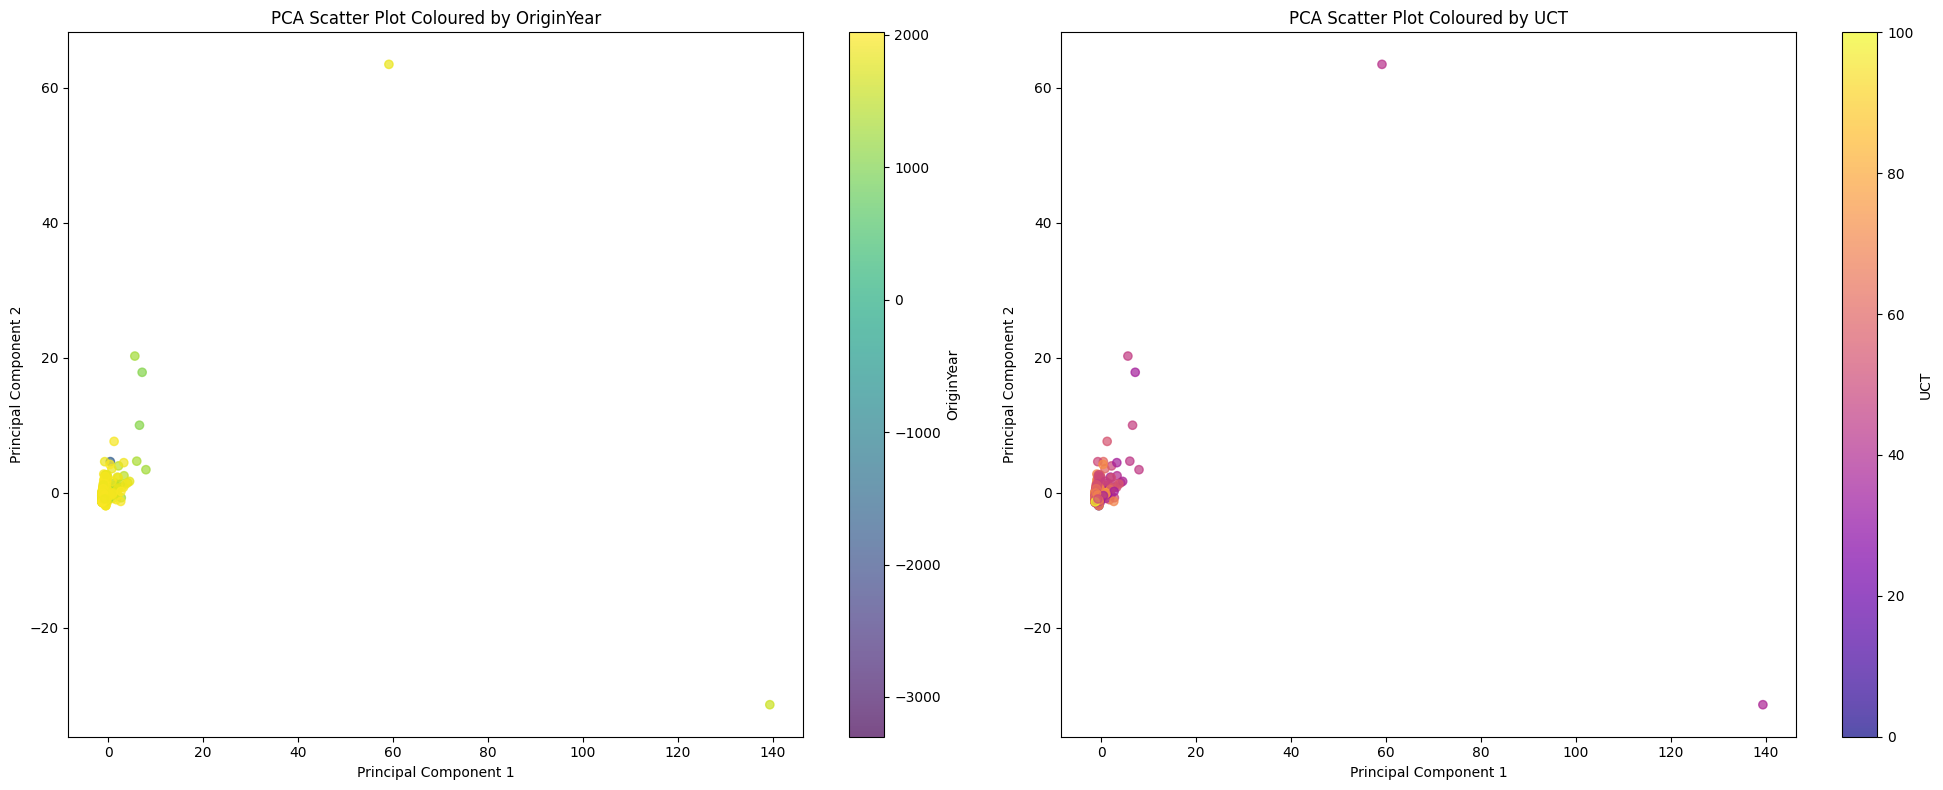

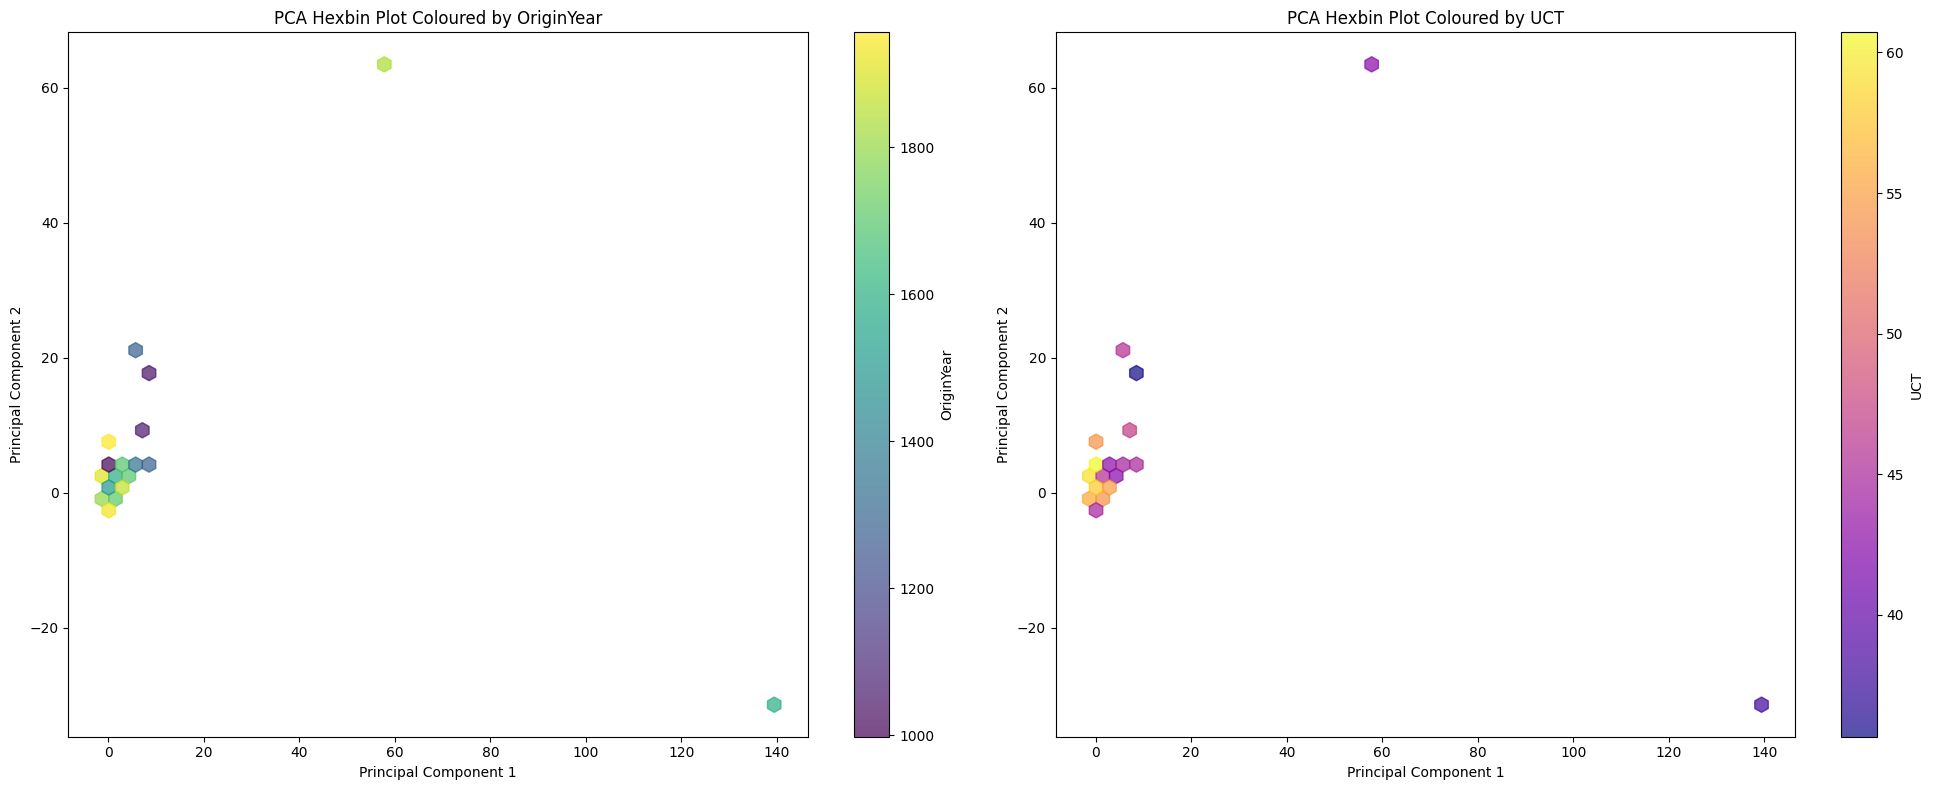

In [ ]:
# Initialise PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_features_imputed_scaled)

# Print PCA Components
print("\nPCA Components:")
print(pca.components_)
print("---------------")


# Create a dataframe for PCA n components
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)
pca_df['OriginYear'] = y_labels_OriginYear.values
pca_df['UCT'] = y_labels_UCT.values

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nExplained Variance Ratio: ")
print(pca.explained_variance_ratio_)
print("---------------")
print(f"Cumulative Explained Variance: {cumulative_variance}")
print("\n---------------")

print()
# Sanity check
print(f"\nOriginal number of features: {X_features_imputed_scaled.shape[1]}")
print(f"\nReduced number of features after PCA: {X_pca.shape[1]}")

print("------------------------")

# Select first two principal components for plotting
pc1 = pca_df['PC1']
pc2 = pca_df['PC2']



##########################################################
#---------------------------Plots-------------------------
##########################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ------------- Scatter Plot: Coloured by OriginYear -----


scatter1 = axes[0].scatter(pc1, pc2,c=pca_df['OriginYear'], cmap='viridis', alpha=0.7)
axes[0].set_title('PCA Scatter Plot Coloured by OriginYear')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('OriginYear')

# ----- Scatter Plot: Coloured by UCT -----
scatter2 = axes[1].scatter(pc1, pc2, c=pca_df['UCT'], cmap='plasma', alpha=0.7)
axes[1].set_title('PCA Scatter Plot Coloured by UCT')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('UCT')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ----- Hexbin Plot: Coloured by OriginYear -----
hb1 = axes[0].hexbin(pc1, pc2, C=pca_df['OriginYear'],gridsize=50, cmap='viridis', reduce_C_function=np.mean, alpha=0.7)
axes[0].set_title('PCA Hexbin Plot Coloured by OriginYear')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
cbar3 = plt.colorbar(hb1, ax=axes[0])
cbar3.set_label('OriginYear')

# ----- Hexbin Plot: Coloured by UCT -----
hb2 = axes[1].hexbin(pc1, pc2, C=pca_df['UCT'],gridsize=50, cmap='plasma', reduce_C_function=np.mean, alpha=0.7)
axes[1].set_title('PCA Hexbin Plot Coloured by UCT')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
cbar4 = plt.colorbar(hb2, ax=axes[1])
cbar4.set_label('UCT')

plt.tight_layout()
plt.show()

## 2.2: Dataset t-SNE Plots Before Applying PCA Deminsionality eduction

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 403 samples in 0.002s...
[t-SNE] Computed neighbors for 403 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 403 / 403
[t-SNE] Mean sigma: 4.315335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.414963
[t-SNE] KL divergence after 1000 iterations: 0.592344


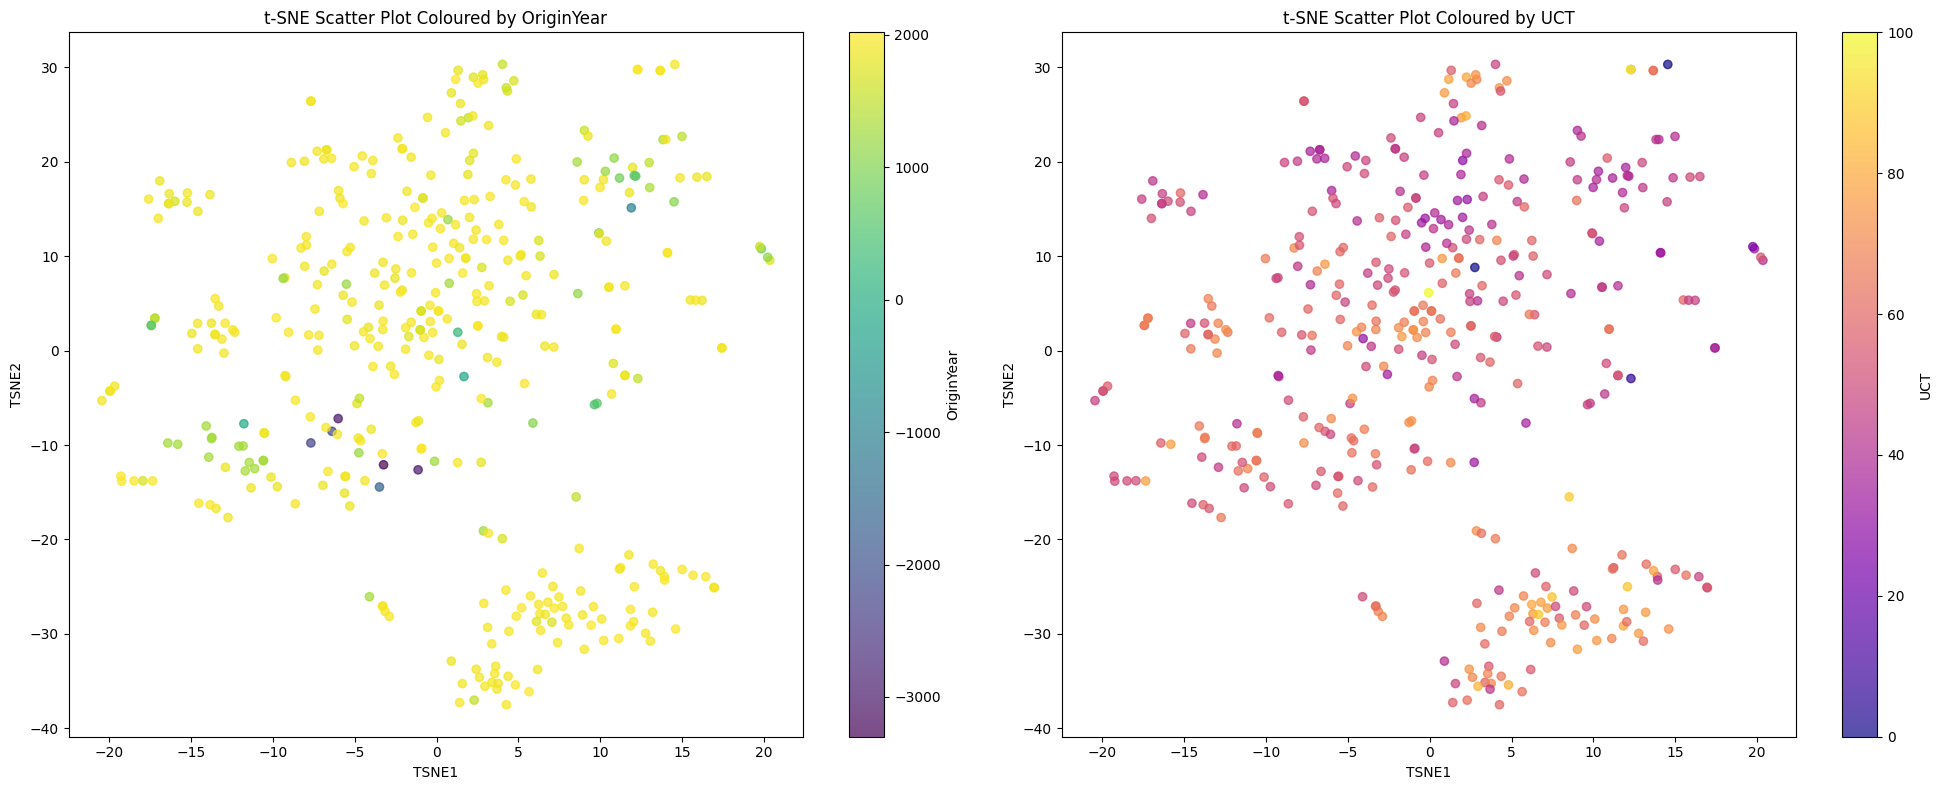

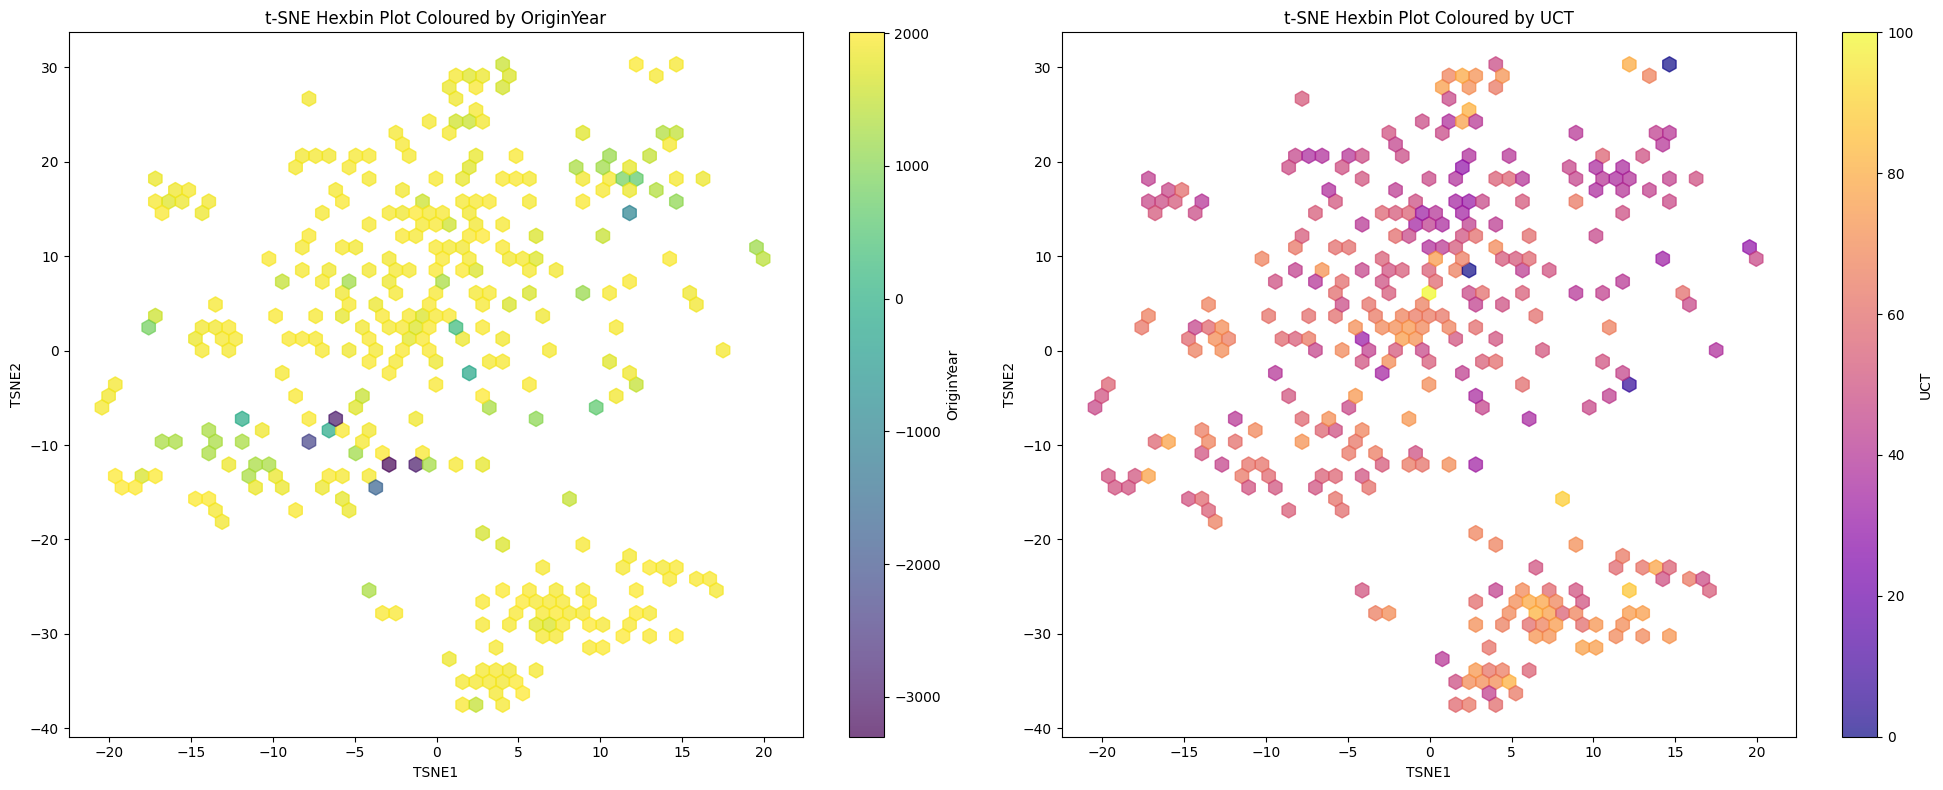

In [ ]:

# Initialise TSNE -- without PCA reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_features_imputed_scaled)

# Create a DataFrame for TSNE results
tsne_df = pd.DataFrame({
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1],
    'OriginYear': y_labels_OriginYear.values,
    'UCT': y_labels_UCT.values
})

# Select TSNE components for plotting
tsne_pc1 = tsne_df['TSNE1']
tsne_pc2 = tsne_df['TSNE2']




##########################################################
#---------------------------Plots-------------------------
##########################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 8))


# ----- Scatter Plot: Coloured by OriginYear -----
scatter1 = axes[0].scatter(tsne_pc1, tsne_pc2, c=tsne_df['OriginYear'], cmap='viridis', alpha=0.7)
axes[0].set_title('t-SNE Scatter Plot Coloured by OriginYear')
axes[0].set_xlabel('TSNE1')
axes[0].set_ylabel('TSNE2')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('OriginYear')

# ----- Scatter Plot: Coloured by UCT -----
scatter2 = axes[1].scatter(tsne_pc1, tsne_pc2, c=tsne_df['UCT'], cmap='plasma', alpha=0.7)
axes[1].set_title('t-SNE Scatter Plot Coloured by UCT')
axes[1].set_xlabel('TSNE1')
axes[1].set_ylabel('TSNE2')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('UCT')

plt.tight_layout()
plt.show()

# ----- Hexbin Plot: Coloured by OriginYear -----
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

hb1 = axes[0].hexbin(tsne_pc1, tsne_pc2, C=tsne_df['OriginYear'],gridsize=50, cmap='viridis', reduce_C_function=np.mean, alpha=0.7)
axes[0].set_title('t-SNE Hexbin Plot Coloured by OriginYear')
axes[0].set_xlabel('TSNE1')
axes[0].set_ylabel('TSNE2')
cbar3 = plt.colorbar(hb1, ax=axes[0])
cbar3.set_label('OriginYear')

# ----- Hexbin Plot: Coloured by UCT -----
hb2 = axes[1].hexbin(tsne_pc1, tsne_pc2, C=tsne_df['UCT'], gridsize=50, cmap='plasma', reduce_C_function=np.mean, alpha=0.7)
axes[1].set_title('t-SNE Hexbin Plot Coloured by UCT')
axes[1].set_xlabel('TSNE1')
axes[1].set_ylabel('TSNE2')
cbar4 = plt.colorbar(hb2, ax=axes[1])
cbar4.set_label('UCT')

plt.tight_layout()
plt.show()


## 2.3: Dataset t-SNE Plots After Applying PCA Deminsionality eduction

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 403 samples in 0.001s...
[t-SNE] Computed neighbors for 403 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 403 / 403
[t-SNE] Mean sigma: 3.017536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.730389
[t-SNE] KL divergence after 1000 iterations: 0.445924


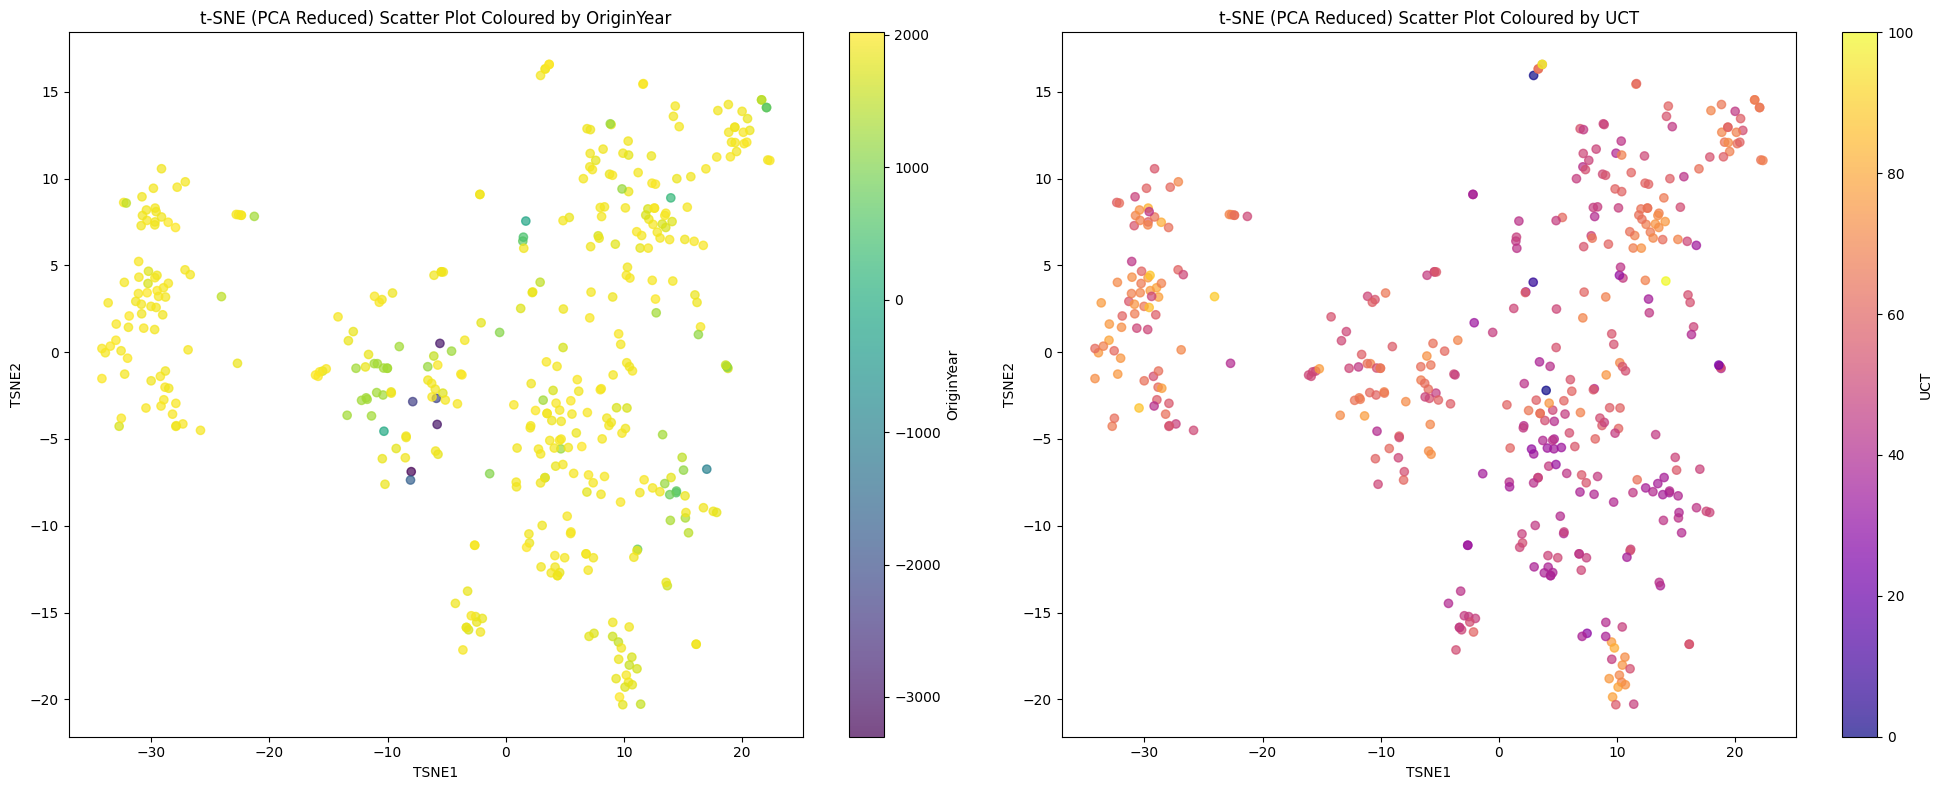

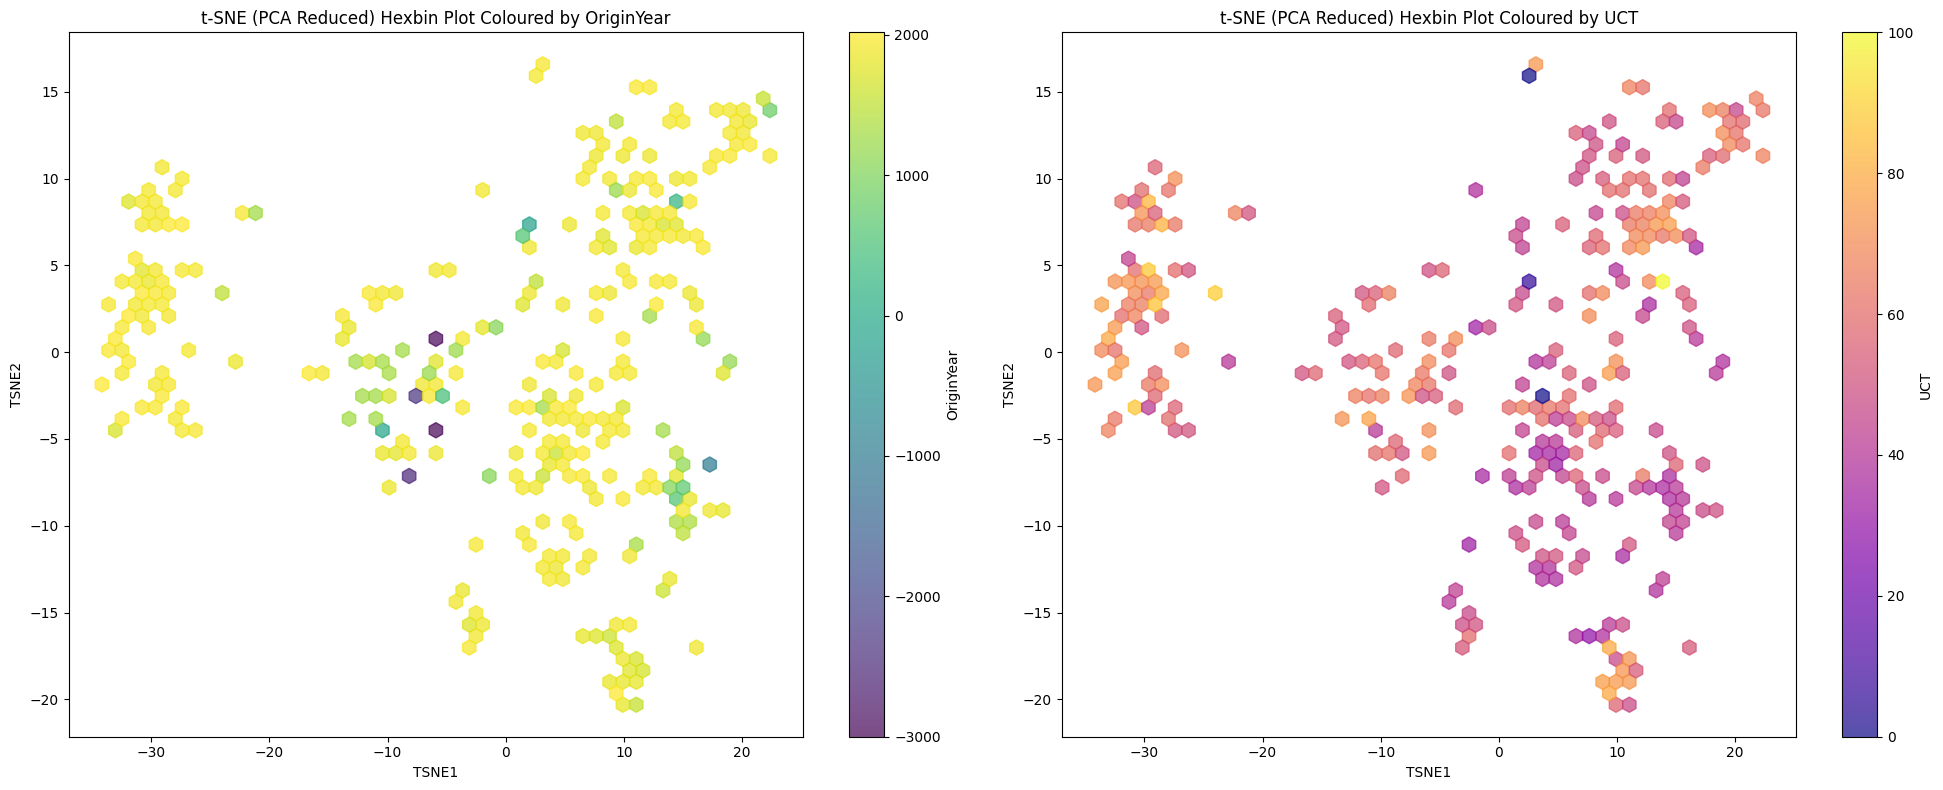

In [ ]:

# Reduce dimensions with PCA before t-SNE
pca_for_tsne = PCA(n_components=50, random_state=42)
X_pca_50 = pca_for_tsne.fit_transform(X_features_imputed_scaled)

# Initialize t-SNE
tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)

# Fit t-SNE on PCA-reduced data
X_tsne_pca = tsne_pca.fit_transform(X_pca_50)

# Create a DataFrame for t-SNE results
tsne_pca_df = pd.DataFrame({
    'TSNE1': X_tsne_pca[:, 0],
    'TSNE2': X_tsne_pca[:, 1],
    'OriginYear': y_labels_OriginYear.values,
    'UCT': y_labels_UCT.values
})

# Select t-SNE components for plotting
tsne_pca_pc1 = tsne_pca_df['TSNE1']
tsne_pca_pc2 = tsne_pca_df['TSNE2']



##########################################################
#---------------------------Plots-------------------------
##########################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ----- Scatter Plot: Colured by OriginYear -----
scatter1 = axes[0].scatter(tsne_pca_pc1, tsne_pca_pc2, c=tsne_pca_df['OriginYear'], cmap='viridis', alpha=0.7)
axes[0].set_title('t-SNE (PCA Reduced) Scatter Plot Coloured by OriginYear')
axes[0].set_xlabel('TSNE1')
axes[0].set_ylabel('TSNE2')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('OriginYear')

# ----- Scatter Plot: Coloured by UCT -----
scatter2 = axes[1].scatter(tsne_pca_pc1, tsne_pca_pc2,c=tsne_pca_df['UCT'], cmap='plasma', alpha=0.7)
axes[1].set_title('t-SNE (PCA Reduced) Scatter Plot Coloured by UCT')
axes[1].set_xlabel('TSNE1')
axes[1].set_ylabel('TSNE2')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('UCT')

plt.tight_layout()
plt.show()

# ----- Hexbin Plot: Coloured by OriginYear -----
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

hb1 = axes[0].hexbin(tsne_pca_pc1, tsne_pca_pc2, C=tsne_pca_df['OriginYear'], gridsize=50, cmap='viridis', reduce_C_function=np.mean, alpha=0.7)
axes[0].set_title('t-SNE (PCA Reduced) Hexbin Plot Coloured by OriginYear')
axes[0].set_xlabel('TSNE1')
axes[0].set_ylabel('TSNE2')
cbar3 = plt.colorbar(hb1, ax=axes[0])
cbar3.set_label('OriginYear')

# ----- Hexbin Plot: Coloured by UCT -----
hb2 = axes[1].hexbin(tsne_pca_pc1, tsne_pca_pc2, C=tsne_pca_df['UCT'], gridsize=50, cmap='plasma', reduce_C_function=np.mean, alpha=0.7)
axes[1].set_title('t-SNE (PCA Reduced) Hexbin Plot Coloured by UCT')
axes[1].set_xlabel('TSNE1')
axes[1].set_ylabel('TSNE2')
cbar4 = plt.colorbar(hb2, ax=axes[1])
cbar4.set_label('UCT')

plt.tight_layout()
plt.show()


## 2.4: K-Means Clustering Analysis

K = 1, Inertia  = 144023.79342263227, Silhouete Score = None
K = 2, Inertia  = 123316.4864793639, Silhouete Score = 0.8231585507760777
K = 3, Inertia  = 119790.02154233443, Silhouete Score = 0.5550710789594806
K = 4, Inertia  = 115423.76578250647, Silhouete Score = 0.5574161461464701
K = 5, Inertia  = 110259.53790227836, Silhouete Score = 0.09313756667340138
K = 6, Inertia  = 109208.177158703, Silhouete Score = 0.08875948087259838
K = 7, Inertia  = 100708.20092006667, Silhouete Score = 0.089200389206317
K = 8, Inertia  = 100286.61494458556, Silhouete Score = 0.0780830590169571
K = 9, Inertia  = 96773.76811599937, Silhouete Score = 0.08808959012853713
K = 10, Inertia  = 95760.62777696743, Silhouete Score = 0.08283458030392547


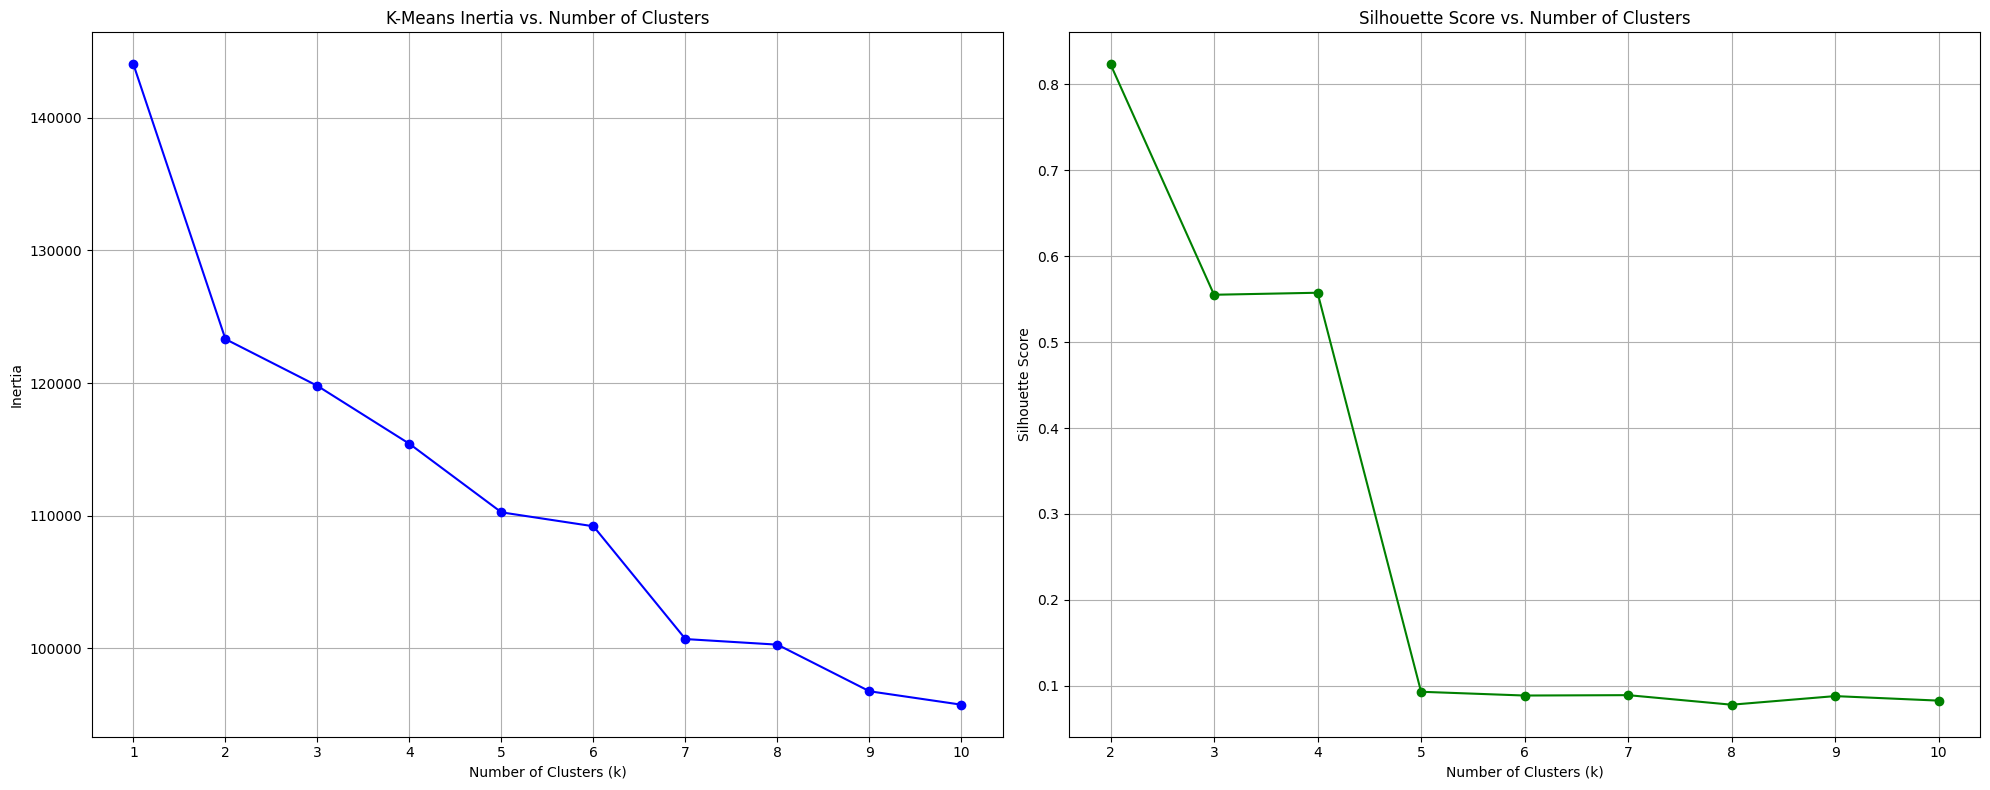

In [ ]:
# Define the range for number of clusters
cluster_range_inertia = range(1, 11)
inertia = []
cluster_range_silhouette = range(2, 11)
silhouette_avg = []

# Calculate inertia and silhouette scores for different ks
for k in cluster_range_inertia:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    score = None
    if k >= 2:
        score = silhouette_score(X_pca, kmeans.labels_)
        silhouette_avg.append(score)
    print(f"K = {k}, Inertia  = {kmeans.inertia_}," + (f" Silhouete Score = {score}"))


##########################################################
#---------------------------Plots-------------------------
##########################################################

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# ----- Plot K-Means Inertia vs. Number of Clusters -----
axes[0].plot(cluster_range_inertia, inertia, marker='o', color='blue')
axes[0].set_title('K-Means Inertia vs. Number of Clusters')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_xticks(cluster_range_inertia)
axes[0].grid(True)

# ----- Plot Silhouette Score vs. Number of Clusters -----
axes[1].plot(cluster_range_silhouette, silhouette_avg, marker='o', color='green')
axes[1].set_title('Silhouette Score vs. Number of Clusters')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_xticks(cluster_range_silhouette)
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 2.5: Preprocessing Dataset After Deminsoniality Reduction and Adding Cluster Features

In [ ]:
# Optimal_k value was determined to be 2 based on previous analysis
optimal_k = 2

# Initialise and fit KMeans with optimal_k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(X_pca)

# Predict clusters for the entire dataset
clusters = kmeans_optimal.labels_

# Assigning cluster labels to PCA and TSNE dataframe
pca_df['Cluster'] = clusters
tsne_df['Cluster'] = clusters[:tsne_df.shape[0]]

# Sanity check
print(f"Clusters shape: {clusters.shape}")
print(f"PCA dataframe shape: {pca_df.shape}")
print(f"TSNE dataframe shape: {tsne_df.shape}")

# Convert cluster labels to a dataframe
cluster_labels = pd.DataFrame({
    'Cluster': clusters
})

# Create a dataframe for PCA components
pca_components_df = pd.DataFrame(
    X_pca,
    columns=pca_columns
)

# Add Cluster Labels to PCA components
pca_with_cluster = pd.concat([pca_components_df, cluster_labels], axis=1)



# Redefining the training and testing feature sets to include 'Cluster' labels
# Determine the number of training samples
n_train = X_train_scaled.shape[0]

# Split PCA data into train and test based on n_train
X_train_pca_split = X_pca[:n_train]
X_test_pca_split = X_pca[n_train:]

# Split cluster labels accordingly
clusters_train = clusters[:n_train]
clusters_test = clusters[n_train:]

# Sanity check
print(f"Number of Training Samples: {n_train}")
print(f"Number of Testing Samples: {X_test_pca_split.shape[0]}")
print("\n-----------------------------------------")

# Create DataFrames for train and test PCA with cluster labels
pca_train_df = pd.DataFrame(X_train_pca_split, columns=pca_columns)
pca_train_df['Cluster'] = clusters_train

pca_test_df = pd.DataFrame(X_test_pca_split, columns=pca_columns)
pca_test_df['Cluster'] = clusters_test

# Sanity check
print(f"PCA Train dataframe shape: {pca_train_df.shape}")
print(f"PCA Test dataframe shape: {pca_test_df.shape}")
print("\n-----------------------------------------")


# For OriginYear
X_train_with_cluster_OriginYear = pca_train_df.copy()
X_test_with_cluster_OriginYear = pca_test_df.copy()

# For UCT
X_train_with_cluster_UCT = pca_train_df.copy()
X_test_with_cluster_UCT = pca_test_df.copy()

print("\nIntegrated Cluster 'Labels' into feature sets for both: OriginYear and UCT --> Done.")
print()
print(f"Shape of X_train_with_cluster_OriginYear: {X_train_with_cluster_OriginYear.shape}")
print(f"Shape of X_test_with_cluster_OriginYear: {X_test_with_cluster_OriginYear.shape}")
print(f"Shape of X_train_with_cluster_UCT: {X_train_with_cluster_UCT.shape}")
print(f"Shape of X_test_with_cluster_UCT: {X_test_with_cluster_UCT.shape}")
print("\n==============================================")

# Sanity checks
print(f"\nDataset before: {X_features_imputed_scaled.shape}")
print(f"OriginYear splits Shapes:")
print(f" X_train_scaled: {X_train_scaled.shape}")
print(f" X_test_scaled: {X_test_scaled.shape}")
print(f" y_train_scaled OriginYear: {y_train_OriginYear_scaled.shape}")
print(f" y_test_scaled OriginYear: {y_test_OriginYear_scaled.shape}")
print(f"\nUCT splits Shapes:")
print(f" y_train_scaled UCT: {y_train_UCT_scaled.shape}")
print(f" y_test_scaled UCT: {y_test_UCT_scaled.shape}")

print("\nFeature sets with cluster labels added:")
print(f"OriginYear Features Shape: {X_train_with_cluster_OriginYear.shape}")
print(f"UCT Features Shape: {X_train_with_cluster_UCT.shape}")

print("\nCluster Labels Shapes:")
print(f"OriginYear Cluster Labels Shape: {y_labels_OriginYear.shape}")
print(f"UCT Cluster Labels Shape: {y_labels_UCT.shape}")


Clusters shape: (403,)
PCA dataframe shape: (403, 101)
TSNE dataframe shape: (403, 5)
Number of Training Samples: 322
Number of Testing Samples: 81

-----------------------------------------
PCA Train dataframe shape: (322, 99)
PCA Test dataframe shape: (81, 99)

-----------------------------------------

Integrated Cluster 'Labels' into feature sets for both: OriginYear and UCT --> Done.

Shape of X_train_with_cluster_OriginYear: (322, 99)
Shape of X_test_with_cluster_OriginYear: (81, 99)
Shape of X_train_with_cluster_UCT: (322, 99)
Shape of X_test_with_cluster_UCT: (81, 99)


Dataset before: (403, 380)
OriginYear splits Shapes:
 X_train_scaled: (322, 380)
 X_test_scaled: (81, 380)
 y_train_scaled OriginYear: (322,)
 y_test_scaled OriginYear: (81,)

UCT splits Shapes:
 y_train_scaled UCT: (322,)
 y_test_scaled UCT: (81,)

Feature sets with cluster labels added:
OriginYear Features Shape: (322, 99)
UCT Features Shape: (322, 99)

Cluster Labels Shapes:
OriginYear Cluster Labels Shape: (

2.6: Outliers Removal

In [ ]:

#  Silhouette scores for each sample
silhouette_vals = silhouette_samples(X_pca, clusters)
pca_df['Silhouette_Val_pca'] = silhouette_vals

# Defining silhouette score threshopld below (0.2)
outliers_pca = pca_df[pca_df['Silhouette_Val_pca'] < 0.2]

print(f"\nNumber of outliers based on PCA KMeans silhouette scores: {outliers_pca.shape[0]}")


non_outliers_pca = pca_df[pca_df['Silhouette_Val_pca'] >= 0.2].index

# Removal of outliers from imputed and scaled feature data
X_features_final = X_features_imputed_scaled.loc[non_outliers_pca].reset_index(drop=True)

# Removeal of outliers from the labels variables
y_UCT_final = y_labels_UCT.loc[non_outliers_pca].reset_index(drop=True)
y_OriginYear_final = y_labels_OriginYear.loc[non_outliers_pca].reset_index(drop=True)

print("\nFinal X_features Shape after uutlier removal:", X_features_final.shape)
print("Final Labels shapes after outlier removal:")
print("OriginYear:", y_OriginYear_final.shape)
print("UCT:", y_UCT_final.shape)



# Performing a single train test split on the filtered data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_features_final,
    pd.concat([y_OriginYear_final, y_UCT_final], axis=1),
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Separate the targets after splitting
y_train_OriginYear = y_train['OriginYear']
y_train_UCT = y_train['UCT']
y_test_OriginYear = y_test['OriginYear']
y_test_UCT = y_test['UCT']

# sanity check
print('------'*20)
print(f"Training X_train shape: {X_train.shape}")
print(f"Testing X_test shape: {X_test.shape}")
print(f"Training y_train 'OriginYear' shape: {y_train_OriginYear.shape}")
print(f"Testing y_test 'OriginYear' shape: {y_test_OriginYear.shape}")
print(f"Training y_train 'UCT' shape: {y_train_UCT.shape}")
print(f"Testing y_test 'UCT' shape: {y_test_UCT.shape}")



Number of outliers based on PCA KMeans silhouette scores: 2

Final X_features Shape after uutlier removal: (401, 380)
Final Labels shapes after outlier removal:
OriginYear: (401,)
UCT: (401,)
------------------------------------------------------------------------------------------------------------------------
Training X_train shape: (320, 380)
Testing X_test shape: (81, 380)
Training y_train 'OriginYear' shape: (320,)
Testing y_test 'OriginYear' shape: (81,)
Training y_train 'UCT' shape: (320,)
Testing y_test 'UCT' shape: (81,)


# 3: Grid Search Cross-Validation - Tuning Hyperparameters


## 3.1 Define Parameter Grids for Each Base Model


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

#  Parameter grids for each base model
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10],
        'min_samples_split': [2],
        'min_samples_leaf': [4],
        'criterion': ['squared_error'],
    },
    'SVR': {
        'C': [ 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.2],
    },
    'KNeighbors': {
        'n_neighbors': [ 7],
        'weights': ['distance'],
        'metric': ['euclidean'],
        'n_jobs': [-1],
        'algorithm': ['auto', 'kd_tree']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [ 0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [1.0],
        'loss': ['absolute_error'],
        'criterion': ['friedman_mse'],
    },
    'AdaBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'loss': ['linear','exponential'],
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01],
        'max_depth': [5],
        'subsample': [0.8],
        'booster': ['gbtree'],
    }
}


def perform_grid_search(model, param_grid, X_train, y_train, scoring='r2', cv=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best {scoring}: {grid_search.best_score_:.4f}\n")
    return grid_search.best_estimator_

## 3.2: Preforming *GridsearchCV()*

In [ ]:

# Dictionary to store best estimators for each target
best_estimators = {
    'UCT': {},
    'OriginYear': {}
}

# Defining target and feature mappings
target_feature_mappings = {
    'UCT': (X_train_with_cluster_UCT, y_train_UCT_scaled),
    'OriginYear': (X_train_with_cluster_OriginYear, y_train_OriginYear_scaled)
}

# Iterate through each target and perform grid search for each model
for target_name, (X_train_feat, y_train_target) in target_feature_mappings.items():
    print(f"Performing Grid Search for target: {target_name}\n{'-'*50}")

    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    best_rf = perform_grid_search(rf, param_grids['RandomForest'], X_train_feat, y_train_target)
    best_estimators[target_name]['RandomForest'] = best_rf

    # SVR
    svr = SVR()
    best_svr = perform_grid_search(svr, param_grids['SVR'], X_train_feat, y_train_target)
    best_estimators[target_name]['SVR'] = best_svr

    # KNeighbors
    knn = KNeighborsRegressor()
    best_knn = perform_grid_search(knn, param_grids['KNeighbors'], X_train_feat, y_train_target)
    best_estimators[target_name]['KNeighbors'] = best_knn

    # Gradient Boosting
    gb = GradientBoostingRegressor(random_state=42)
    best_gb = perform_grid_search(gb, param_grids['GradientBoosting'], X_train_feat, y_train_target)
    best_estimators[target_name]['GradientBoosting'] = best_gb

    # AdaBoost
    ada = AdaBoostRegressor(random_state=42)
    best_ada = perform_grid_search(ada, param_grids['AdaBoost'], X_train_feat, y_train_target)
    best_estimators[target_name]['AdaBoost'] = best_ada

    # XGBoost
    xgb = XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42)
    best_xgb = perform_grid_search(xgb, param_grids['XGBoost'], X_train_feat, y_train_target)
    best_estimators[target_name]['XGBoost'] = best_xgb

    print(f"Completed Grid Search for target: {target_name}\n{'='*50}\n")

print("Grid Search Completed for All Models and Targets.")

Performing Grid Search for target: UCT
--------------------------------------------------
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for RandomForestRegressor: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best r2: -0.0987

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for SVR: {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
Best r2: -0.0421

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for KNeighborsRegressor: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 7, 'weights': 'distance'}
Best r2: -0.2330

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for GradientBoostingRegressor: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best r2: -0.1247

Fitting 5 folds for each of 

# 4: Training and Evaluating Random Forest Model

## 4.1: Train Random Forrest Regressor Model (Bagging)

In [ ]:

for target_name in ['UCT', 'OriginYear']:
    print(f"Training Random Forest Regressor for label: {target_name}\n{'-'*50}")

    # Retrieve best Random Forest estimator from grid search
    best_rf = best_estimators[target_name]['RandomForest']

    # Retrieve corresponding test set
    if target_name == 'UCT':
        X_test = X_test_with_cluster_UCT
        y_test = y_test_UCT_scaled
    elif target_name == 'OriginYear':
        X_test = X_test_with_cluster_OriginYear
        y_test = y_test_OriginYear_scaled

    # Predict on the test data
    y_pred_rf = best_rf.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred_rf)
    mae = mean_absolute_error(y_test, y_pred_rf)
    r2 = r2_score(y_test, y_pred_rf)

    standalone_rf[target_name] = best_rf

    print(f"\nMetrics for Random Forest Regressor  ('{target_name}'):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}\n{'='*50}\n")


Training Random Forest Regressor for label: UCT
--------------------------------------------------

Metrics for Random Forest Regressor  ('UCT'):
Mean Squared Error (MSE): 162.997792667747
Mean Absolute Error (MAE): 11.05517548470036
R-squared (R2): -0.010110417544082484

Training Random Forest Regressor for label: OriginYear
--------------------------------------------------

Metrics for Random Forest Regressor  ('OriginYear'):
Mean Squared Error (MSE): 1063294.5492956373
Mean Absolute Error (MAE): 452.48246127991973
R-squared (R2): -0.03812188378471526



# 5: Build and Evaluate Stacking Ensemble


In [ ]:
# Dictionary to store Stacking Regressors
stacking_regressors = {
    'UCT': None,
    'OriginYear': None
}

for target_name in ['UCT', 'OriginYear']:
    print(f"Stacking Ensemble for target: {target_name}\n{'-'*50}")

    # Retrieve the best estimators for current targets
    estimators = [
        ('RandomForest', best_estimators[target_name]['RandomForest']),
        ('SVR', best_estimators[target_name]['SVR']),
        ('KNeighbors', best_estimators[target_name]['KNeighbors']),
        ('GradientBoosting', best_estimators[target_name]['GradientBoosting']),
        ('AdaBoost', best_estimators[target_name]['AdaBoost']),
        ('XGBoost', best_estimators[target_name]['XGBoost'])
    ]

    # Defining stacking meta-learner
    final_estimator = RandomForestRegressor(random_state=42)

    # Initialiae the Stacking Regressor
    stacking_clf = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=True  # Pass original features to meta learneer
    )

    # Retrieve corresponding training and testing data
    if target_name == 'UCT':
        X_train_feat = X_train_with_cluster_UCT
        y_train_target = y_train_UCT_scaled
        X_test_feat = X_test_with_cluster_UCT
        y_test_target = y_test_UCT_scaled
    elif target_name == 'OriginYear':
        X_train_feat = X_train_with_cluster_OriginYear
        y_train_target = y_train_OriginYear_scaled
        X_test_feat = X_test_with_cluster_OriginYear
        y_test_target = y_test_OriginYear_scaled

    # Train the Stacking Regressor
    stacking_clf.fit(X_train_feat, y_train_target)
    stacking_regressors[target_name] = stacking_clf

    # Predict on the test data
    y_pred_stack = stacking_clf.predict(X_test_feat)

    # Calculate metrics
    mse = mean_squared_error(y_test_target, y_pred_stack)
    mae = mean_absolute_error(y_test_target, y_pred_stack)
    r2 = r2_score(y_test_target, y_pred_stack)

    print(f"\nMetrics for Stacking Ensemble ('{target_name}'):")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    print(f"\n{'='*50}\n")


Stacking Ensemble for target: UCT
--------------------------------------------------

Metrics for Stacking Ensemble ('UCT'):
Mean Squared Error (MSE): 173.47703067668343
Mean Absolute Error (MAE): 11.192160232121026
R-squared (R2): -0.07505109746069549


Stacking Ensemble for target: OriginYear
--------------------------------------------------

Metrics for Stacking Ensemble ('OriginYear'):
Mean Squared Error (MSE): 1105884.6779064918
Mean Absolute Error (MAE): 484.0411263962375
R-squared (R2): -0.0797037244641603




# 6: Cross-Validation for Random Forest and Stacking Ensemble





In [ ]:
# Ensuring all features are imputed before cross val
imputer = KNNImputer(n_neighbors=5)
X_features_imputed = pd.DataFrame(imputer.fit_transform(X_features), columns=X_features.columns)


for target_name in ['UCT', 'OriginYear']:
    print(f"Cross-Validation for Random Forest ('{target_name}')\n{'-'*50}")

    # Retrieves best Random Forest estimator
    best_rf = best_estimators[target_name]['RandomForest']

    # Perform 5-fold cross-validation while looping scoring metrics
    for scoring_metric in ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']:
        cv_scores_rf = cross_val_score(
            best_rf,
            X_features_imputed,
            data[target_name],
            cv=5,
            scoring=scoring_metric,
            n_jobs=-1
        )
        print(f"Cross-Validation Scores ({scoring_metric}) : {cv_scores_rf}")

        # Print the scores for current metric
        if scoring_metric == 'neg_mean_squared_error':
            print("Mean Squared Error:", -cv_scores_rf.mean()) # Negate for MSE
        elif scoring_metric == 'neg_mean_absolute_error':
            print("Mean Absolute Error:", -cv_scores_rf.mean()) # Negate for MAE
        else:
            print("R-squared:", cv_scores_rf.mean())

        print(f"\n{'='*50}\n")


    print(f"Cross-Validation for Stacking Regressor ('{target_name}')\n{'-'*50}")


    # Retrieves Stacking Regressor
    stacking_clf = stacking_regressors[target_name]

    for scoring_metric in ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']:
        # Performing 5-fold cross-validation while looping scoring metrics
        cv_scores_stack = cross_val_score(
            stacking_clf,
            X_features_imputed,
            data[target_name],
            cv=5,
            scoring=scoring_metric,
            n_jobs=-1
        )
        print(f"Cross-Validation Scores ({scoring_metric}) : {cv_scores_stack}")

        # Print the scores for current metric
        if scoring_metric == 'neg_mean_squared_error':
            print("Mean Squared Error:", -cv_scores_stack.mean()) # Negate for MSE
        elif scoring_metric == 'neg_mean_absolute_error':
            print("Mean Absolute Error:", -cv_scores_stack.mean()) # Negate for MAE
        else:
            print("R-squared:", cv_scores_stack.mean())

        print(f"\n{'='*50}\n")


Cross-Validation for Random Forest ('UCT')
--------------------------------------------------
Cross-Validation Scores (neg_mean_squared_error) : [-178.4558932  -104.01705723  -92.44786972 -165.84353088 -140.72777101]
Mean Squared Error: 136.2984244071788


Cross-Validation Scores (neg_mean_absolute_error) : [-8.9047045  -8.12353876 -7.3689396  -8.32930071 -8.35693821]
Mean Absolute Error: 8.216684356284004


Cross-Validation Scores (r2) : [0.18695053 0.46942067 0.37125015 0.20576212 0.04985188]
R-squared: 0.2566470710318739


Cross-Validation for Stacking Regressor ('UCT')
--------------------------------------------------
Cross-Validation Scores (neg_mean_squared_error) : [-165.81648169 -120.96995316  -90.26840978 -165.70493151 -140.17138375]
Mean Squared Error: 136.58623197828217


Cross-Validation Scores (neg_mean_absolute_error) : [-8.40010188 -8.79263643 -7.5098615  -8.21940988 -8.62774025]
Mean Absolute Error: 8.309949985159053


Cross-Validation Scores (r2) : [0.244536   0.38294

# 7: Final Cross-Validation Testing on Unseen Dataset (GameData_Predictions.csv)

## 7.1: Preprocessing Datasets

In [ ]:

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Load the training dataset
data_train = pd.read_csv('GameData.csv')

print("Training Data Snapshot:")
print(data_train.head())

# Load the prediction dataset
data_predictions = pd.read_csv('GameData_Predictions.csv')

print("\nPrediction Data Snapshot:")
print(data_predictions.head())

# insuring the prediction dataset same columns as the training dataset
columns_to_keep = [col for col in data_train.columns if col != 'GameName' and col not in ['UCT', 'OriginYear', 'Category', 'Region', 'BestAgent']]
X_train = data_train[columns_to_keep]  # Features
y_train_UCT = data_train['UCT']
y_train_OriginYear = data_train['OriginYear']


X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train_imputed.columns)


print("\nShape of scaled prediction feature matrix:", X_features_scaled_predictions.shape)



Training Data Snapshot:
              GameName  String_java.lang.String  Off_int  End_int  int_int  \
0                Senet                       55        2        2     18.0   
1  Ludus Latrunculorum                        7        0        0      NaN   
2          XII Scripta                        8        3        3      NaN   
3                Mehen                       25        4        6    203.0   
4           20 Squares                       16        1        1    116.0   

   Undefined_int  Piece_game.equipment.component.Piece  \
0              0                                     1   
1              0                                     1   
2              0                                     1   
3              0                                     3   
4              0                                     1   

   Board_game.equipment.container.board.Board  \
0                                         1.0   
1                                         1.0   
2          

## 7.2: Preforming Cross-Validation on Random Forrest Regressor and Stacking Ensamble

In [ ]:


# Cross-validation for Random Forest Regressor and Stacking Regressor models on both labels (OriginYear,UCT)
for target_name, y_train in [('UCT', y_train_UCT), ('OriginYear', y_train_OriginYear)]:
    if target_name in data_train.columns:
        print(f"Cross-Validation for Random Forest ('{target_name}')\n{'-'*50}")
        # Perform 5-fold cross-validation while looping scoring metrics
        for scoring_metric in ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']:
            cv_scores_rf = cross_val_score(
                best_rf,
                X_train_scaled,
                y_train,
                cv=5,
                scoring=scoring_metric,
                n_jobs=-1
            )
            print(f"Cross-Validation Scores ({scoring_metric}) : {cv_scores_rf}")

            # Print the scores for current metric
            if scoring_metric == 'neg_mean_squared_error':
                print("Mean Squared Error:", -cv_scores_rf.mean()) # Negate for MSE
            elif scoring_metric == 'neg_mean_absolute_error':
                print("Mean Absolute Error:", -cv_scores_rf.mean()) # Negate for MAE
            else:
                print("R-squared:", cv_scores_rf.mean())

            print(f"\n{'='*50}\n")


        print(f"Cross-Validation for Stacking Regressor ('{target_name}')\n{'-'*50}")

        # Retrieves Stacking Regressor
        stacking_clf = stacking_regressors[target_name]

        for scoring_metric in ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']:
           # Performing 5-fold cross-validation while looping scoring metrics
            cv_scores_stack = cross_val_score(
            stacking_clf,
            X_train_scaled,
            y_train_UCT,
            cv=5,
            scoring=scoring_metric,
            n_jobs=-1)

            print(f"Cross-Validation Scores ({scoring_metric}) : {cv_scores_stack}")

            # Print the scores for current metric
            if scoring_metric == 'neg_mean_squared_error':
                print("Mean Squared Error:", -cv_scores_stack.mean())
            elif scoring_metric == 'neg_mean_absolute_error':
                print("Mean Absolute Error:", -cv_scores_stack.mean())
            else:
                print("R-squared:", cv_scores_stack.mean())

            print(f"\n{'='*50}\n")

Cross-Validation for Random Forest ('UCT')
--------------------------------------------------
Cross-Validation Scores (neg_mean_squared_error) : [-174.44263235 -104.66882703  -91.01304163 -163.09187197 -138.94703977]
Mean Squared Error: 134.43268255004972


Cross-Validation Scores (neg_mean_absolute_error) : [-8.81849266 -8.18478382 -7.3765733  -8.2433117  -8.40265784]
Mean Absolute Error: 8.205163864036845


Cross-Validation Scores (r2) : [0.20523504 0.46609607 0.3810086  0.21894003 0.0618748 ]
R-squared: 0.26663090968098074


Cross-Validation for Stacking Regressor ('UCT')
--------------------------------------------------
Cross-Validation Scores (neg_mean_squared_error) : [-149.41303514  -98.05058978  -90.58995472 -147.25323612 -132.54458312]
Mean Squared Error: 123.57027977389085


Cross-Validation Scores (neg_mean_absolute_error) : [-7.97110741 -7.90519414 -7.31096756 -8.19898972 -8.50683116]
Mean Absolute Error: 7.978617998865014


Cross-Validation Scores (r2) : [0.31927051 0.499

# Appendix

## 1: Previously Tried Grid Search Hyperparamters


In [ ]:

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}
